In [1]:
# default_exp preprocess

In [2]:
#export
from fastai2.basics import *
from nbdev.export import *
import re

In [3]:
#export
data_path = Path('/mnt/data1/wamri/physionet2020')
data_path_trn = data_path/'Training_WFDB'


proc_path = data_path/'processed'
trn_path = proc_path/'trn'
meta_path = proc_path/'meta'
trn_path.mkdir(exist_ok=True)
meta_path.mkdir(exist_ok=True)

meta_trn_pth = meta_path/'df_trn.csv'

In [4]:
# Run this if you change any of the paths above
notebook2script()

Converted 00_core.ipynb.
Converted 01_preprocess.ipynb.
Converted 02_train.ipynb.
Converted index.ipynb.


## Data:

https://physionetchallenges.github.io/2020/

```
The initial training set is the public data used in the China Physiological Signal Challenge in 2018 (CPSC2018), held during the 7th International Conference on Biomedical Engineering and Biotechnology in Nanjing, China. This training set consists of 6,877 (male: 3,699; female: 3,178) 12-ECG recordings lasting from 6 seconds to 60 seconds. Each recording was sampled at 500 Hz. All data is provided in WFDB format with a MATLAB v4 file and a header containing patient sex, age, and diagnosis (Dx) information at the end of the header file.

Each ECG recording has one or more labels from one normal sinus rhythm type and eight abnormal types:

Normal sinus rhythm (Normal)
Atrial fibrillation (AF)
First-degree atrioventricular block (I-AVB)
Left bundle branch block (LBBB)
Right bundle branch block (RBBB)
Premature atrial complex (PAC)
Premature ventricular complex (PVC)
ST-segment depression (STD)
ST-segment elevation (STE)
```

## Load files

In [4]:
trn_files = data_path_trn.ls()
len(trn_files)

13754

## Load Header

In [5]:
f_hea, f_mat = trn_files[:2]
file1 = open(f_hea, "r") 
lines = file1.readlines()
lines

['A1516 12 500 13500 05-Feb-2020 11:39:16\n',
 'A1516.mat 16+24 1000/mV 16 0 -64 6322 0 I\n',
 'A1516.mat 16+24 1000/mV 16 0 58 -4227 0 II\n',
 'A1516.mat 16+24 1000/mV 16 0 123 2951 0 III\n',
 'A1516.mat 16+24 1000/mV 16 0 2 -521 0 aVR\n',
 'A1516.mat 16+24 1000/mV 16 0 -94 -4652 0 aVL\n',
 'A1516.mat 16+24 1000/mV 16 0 90 5305 0 aVF\n',
 'A1516.mat 16+24 1000/mV 16 0 64 -1292 0 V1\n',
 'A1516.mat 16+24 1000/mV 16 0 -49 3744 0 V2\n',
 'A1516.mat 16+24 1000/mV 16 0 43 226 0 V3\n',
 'A1516.mat 16+24 1000/mV 16 0 -391 4019 0 V4\n',
 'A1516.mat 16+24 1000/mV 16 0 -316 -4905 0 V5\n',
 'A1516.mat 16+24 1000/mV 16 0 -147 3701 0 V6\n',
 '#Age: 82\n',
 '#Sex: Male\n',
 '#Dx: PAC\n',
 '#Rx: Unknown\n',
 '#Hx: Unknown\n',
 '#Sx: Unknows\n']

In [6]:
# Regex to parse keys and values
m = re.match('#(.*):\s(.*)\\n', lines[-1])
m.groups()

('Sx', 'Unknows')

## Parse Header

In [7]:
#export
cols = ['Normal','AF','I-AVB','LBBB','RBBB','PAC','PVC','STD','STE']

In [8]:
def parse_hea(path_hea):
    res = {}
    with open(path_hea, "r") as f: lines = f.readlines()
    for l in lines:
        m = re.match('#(.*):\s(.*)\\n', l)
        if m is None: continue
        k,v = m.groups()
        res[k] = v
    res['PID'] = path_hea.stem
    
    lbls = set(res['Dx'].split(','))
    for c in cols: res[c] = int(c in lbls)
    return res

In [9]:
parse_hea(f_hea)

{'Age': '82',
 'Sex': 'Male',
 'Dx': 'PAC',
 'Rx': 'Unknown',
 'Hx': 'Unknown',
 'Sx': 'Unknows',
 'PID': 'A1516',
 'Normal': 0,
 'AF': 0,
 'I-AVB': 0,
 'LBBB': 0,
 'RBBB': 0,
 'PAC': 1,
 'PVC': 0,
 'STD': 0,
 'STE': 0}

## Create CSV

In [10]:
fns_hea = list(data_path_trn.glob('*.hea')); len(fns_hea)

6877

In [11]:
parsed_hea = [parse_hea(f) for f in progress_bar(fns_hea)]

In [12]:
df_hea = pd.DataFrame(parsed_hea)

In [13]:
df_hea.head()

,Age,Sex,Dx,Rx,Hx,Sx,PID,Normal,AF,I-AVB,LBBB,RBBB,PAC,PVC,STD,STE
0,82,Male,PAC,Unknown,Unknown,Unknows,A1516,0,0,0,0,0,1,0,0,0
1,87,Female,RBBB,Unknown,Unknown,Unknows,A2989,0,0,0,0,1,0,0,0,0
2,75,Female,"AF,RBBB",Unknown,Unknown,Unknows,A0109,0,1,0,0,1,0,0,0,0
3,24,Female,Normal,Unknown,Unknown,Unknows,A3465,1,0,0,0,0,0,0,0,0
4,65,Male,PVC,Unknown,Unknown,Unknows,A5081,0,0,0,0,0,0,1,0,0


In [14]:
df_hea.to_csv(meta_trn_pth, index=False)

In [15]:
df_hea[cols].mean()

Normal    0.133488
AF        0.177548
I-AVB     0.104988
LBBB      0.034317
RBBB      0.270031
PAC       0.089574
PVC       0.101789
STD       0.126363
STE       0.031991
dtype: float64

## Load EKG

In [14]:
from scipy.io import loadmat
import ecg_plot

In [15]:
d_mat = loadmat(str(f_mat))

In [16]:
d_arr = d_mat['val']
d_arr.shape, d_arr.min(axis=1), d_arr.max(axis=1)

((12, 11500),
 array([ -346, -1559, -1955,  -471,  -351, -1745, -1203, -1227, -1552,
         -953,  -717,  -685], dtype=int16),
 array([ 527,  730,  633,  594, 1223,  645,  730,  586,  540,  561,  464,
         971], dtype=int16))

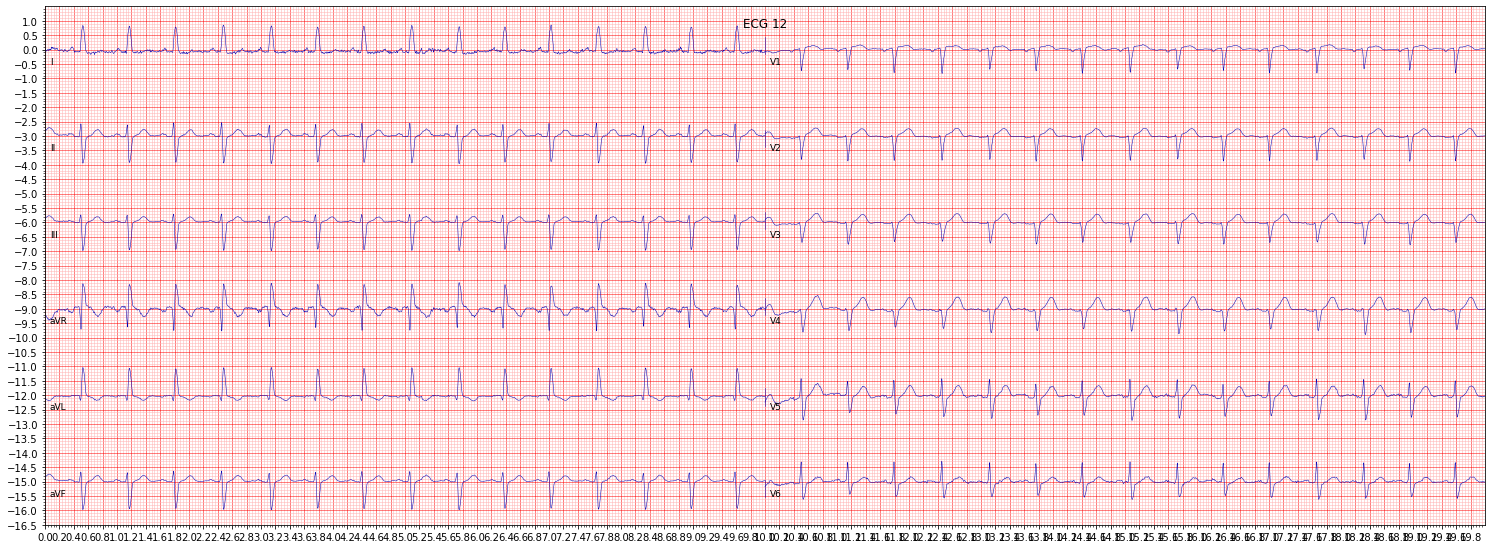

In [17]:
d_norm = d_arr/np.absolute(d_arr).max(axis=1, keepdims=True)

# Dataset is sampled at 500 hz
ecg_plot.plot(d_norm[:, :5000], sample_rate=500, title='ECG 12')

## Concat all data

In [18]:
fns_mat = list(data_path_trn.glob('*.mat'))
res = [loadmat(str(f))['val'] for f in progress_bar(fns_mat)]

In [19]:
len(res)

6877

In [20]:
shapes = [x.shape for x in res]

(array([5.463e+03, 1.008e+03, 2.800e+02, 1.000e+02, 1.400e+01, 2.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([ 3000.,  9900., 16800., 23700., 30600., 37500., 44400., 51300.,
        58200., 65100., 72000.]),
 <a list of 10 Patch objects>)

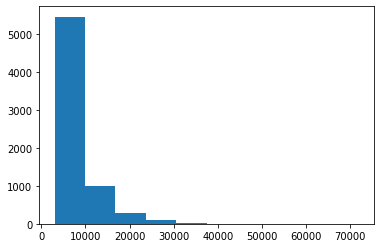

In [21]:
# Histogram of time
plt.hist(list(zip(*shapes))[1])

In [22]:
res_cat = np.concatenate(res, axis=1); res_cat.shape

(12, 54837488)

## Normalization

In [23]:
xmin,xmax = [getattr(res_cat, k)(axis=1, keepdims=True) for k in progress_bar(['min', 'max'])]
res_norm = (res_cat-xmin)/(xmax-xmin)
res_norm.mean(), res_norm.std()

(-0.7698600893714851, 0.1618842381076718)

## Standardization

In [24]:
xmean,xstd = [getattr(res_norm, k)(axis=1, keepdims=True) for k in progress_bar(['mean', 'std'])]
res_stand = (res_norm-xmean)/xstd
res_stand.std(axis=1), res_stand.mean(axis=1)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([-3.26278420e-13,  4.97793455e-14,  3.69803293e-14,  5.70874390e-14,
        -8.98578680e-14, -4.35075200e-14, -3.48413396e-14, -1.73039108e-13,
        -1.48909110e-13, -4.58917253e-14, -8.06888448e-15,  1.17517602e-13]))

## Save

In [150]:
res_decat = []
start_idx = 0
for (x,y) in shapes:
    end_idx = start_idx+y
    res_decat.append(res_stand[:, start_idx:end_idx])
    start_idx = end_idx

In [157]:
for fn,arr in progress_bar(list(zip(fns_mat, res_decat))):
    out_pth = trn_path/fn.with_suffix('.npy').name
    np.save(str(out_pth), arr)

## Export

In [12]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_preprocess.ipynb.
Converted 02_train.ipynb.
Converted index.ipynb.
